In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib as im

# Getting in scope data

In [37]:
data = pd.read_csv("data/train_test/train.csv")

In [38]:
features = [feature for feature in list(data.columns) if "Unnamed" not in feature]
data = data[features]

In [41]:
np.unique(data["EVENT TYPE"])

array(['Billing (in scope)', 'Billing (not in scope)', 'Credit Note',
       'Delivery (in scope)', 'Delivery (not in scope)', 'Document flow',
       'Document management - Invoice (in scope)',
       'Document management - Invoice (not in scope)',
       'Document management - PO',
       'Document management - PO approval - indicator',
       'Document management - PO approval - status',
       'Document management - PR', 'Payment (in scope)',
       'Payment (not in scope)', 'Purchasing document'], dtype=object)

In [50]:
np.unique(data["SIMPLIFIED EVENT"])

array([' cancel)', 'Approved', 'BLOCKED', 'Blocked',
       'Clearing (Credit memo)', 'Clearing (Invoice)',
       'Consumption (Subcontracting)', 'Credit Note',
       'Credit Note header updated', 'Credit Note item updated',
       'Delivery (Stock Transfer)', 'Goods Issue for Stock Transfer',
       'Goods Reciept', 'Goods Return', 'Invoice Reciept',
       'Invoice Reciept (Logistics invoice) blocked',
       'Invoice Reciept (Logistics invoice) released',
       'Invoice Reciept header updated', 'Invoice Reciept item updated',
       'Permanently blocked', 'Purchase order',
       'Purchase order header updated', 'Purchase order item updated',
       'Purchase requisition', 'Purchase requisition item updated',
       'RELEASED', 'RELEASED (10% delta possible)',
       'RELEASED (5% delta possible)', 'Service Entry Sheet'],
      dtype=object)

In [51]:
np.unique(data[data["EVENT TYPE"] =='Payment (in scope)']["SIMPLIFIED EVENT"])

array(['Clearing (Credit memo)', 'Clearing (Invoice)'], dtype=object)

In [49]:
np.unique(data[data["EVENT TYPE"] =='Document management - PO approval - status']["SIMPLIFIED EVENT"])

array(['Approved', 'Blocked'], dtype=object)

In [45]:
np.unique(data[data["EVENT"] =='Purchase order']["EVENT TYPE"])

array(['Purchasing document'], dtype=object)

In [39]:
cases = np.unique(data["CASE"])

In [77]:
def has_clearing(case, data):
    clearings = np.unique(data[data["EVENT TYPE"] =='Payment (in scope)']["SIMPLIFIED EVENT"])
    for clearing in clearings:
        if clearing in case:
            return True
    return False
v1 = 0
v2 = 0
new_cases = []
for case_id in tqdm_notebook(cases):
    case = list(data[data["CASE"] == case_id]["SIMPLIFIED EVENT"])
#     print(case)
    clearing = has_clearing(case, data)
#     if clearing == True:
#         print("clearing")
    purchase_order = 'Purchase order' in case
#     if purchase_order == True:
#         print("purchase order")
    goods_return = "Goods Return" in case
#     if goods_return == True:
#         print("goods reciept")
    if purchase_order and clearing:
        v1 += 1
    if purchase_order and goods_return:
        v2 += 1
    if (purchase_order and clearing) or (purchase_order and goods_return):
        new_cases.append(case_id)

In [71]:
v1

1107

In [72]:
v2

184

In [78]:
len(new_cases)

1240

In [82]:
data_in_scope = data.set_index("CASE").loc[new_cases].reset_index()

In [83]:
data_in_scope.to_csv("data/train_test/train(in scope).csv")

In [66]:
import processmining.preprocessing as pr

In [95]:
log, paths, betas = prune(Log.from_csv("data/train_test/train(in scope).csv", do_sort=True), top=5)

INFO:root:Reading...
INFO:root:Pruning...


In [96]:
paths

['UMaOF', 'UBZMOF', 'UXBMOF', 'UaMOF', 'UBXMOF']

In [97]:
betas

[0.029838709677419355,
 0.02338709677419355,
 0.02258064516129032,
 0.021774193548387097,
 0.020967741935483872]

In [3]:
from processmining.miners import AlphaMiner

In [98]:
am = AlphaMiner()

In [99]:
clean(log, inplace=True);

INFO:root:Cleaning...


In [102]:
am.apply(log)

DEBUG:root:Got task list
DEBUG:root:Got direct follows
DEBUG:root:Got causaieties
DEBUG:root:Got cycles
DEBUG:root:Got not causaieties
DEBUG:root:Got parallels
DEBUG:root:Got subsets
INFO:root:Processing 254 subset of 8 events
DEBUG:root:Got Xl
DEBUG:root:Building Petri net


In [104]:
am.draw(output_file="pic/top5model")

In [123]:
log, paths, betas = prune(Log.from_csv("data/train_test/train(in scope).csv", do_sort=True), top=6)

INFO:root:Reading...
INFO:root:Pruning...


In [124]:
paths

['UMaOF', 'UBZMOF', 'UXBMOF', 'UaMOF', 'UBXMOF', 'UKLOMQSF']

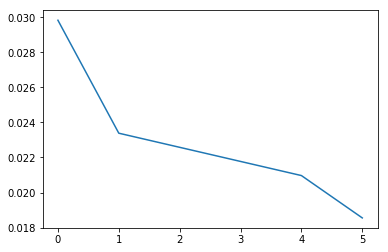

In [125]:
plt.plot(betas)
plt.show()

In [126]:
am.apply(log)

DEBUG:root:Got task list
DEBUG:root:Got direct follows
DEBUG:root:Got causaieties
DEBUG:root:Got cycles
DEBUG:root:Got not causaieties
DEBUG:root:Got parallels
DEBUG:root:Got subsets
INFO:root:Processing 4094 subset of 12 events
DEBUG:root:Got Xl
DEBUG:root:Building Petri net


In [128]:
am.draw(output_file="pic/top6model")

# Paths clustering. Events embedding 

In [640]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [641]:
log = Log.from_csv("data/train_test/train(in scope).csv", do_sort=True)

INFO:root:Reading...


In [642]:
docs = []
for i, case in enumerate(log):
    docs.append(TaggedDocument(case, [i]))

In [643]:
dv = Doc2Vec(docs, dm=0, size=100, window=3, min_count=0)

DEBUG:gensim.models.word2vec:Fast version of gensim.models.word2vec is being used
INFO:gensim.models.doc2vec:collecting all words and their counts
INFO:gensim.models.doc2vec:PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO:gensim.models.doc2vec:collected 27 word types and 1240 unique tags from a corpus of 1240 examples and 13506 words
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:min_count=0 retains 27 unique words (100% of original 27, drops 0)
INFO:gensim.models.word2vec:min_count=0 leaves 13506 word corpus (100% of original 13506, drops 0)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 27 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 18 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 1927 word corpus (14.3% of prior 13506)
INFO:gensim.models.word2vec:estimated required memory for 27 words and 100 dimensions: 531100 bytes
INFO:gensim.models.word2vec:resetting la

In [644]:
diffs = np.array([dv.infer_vector(case) for case in log])

In [645]:
from sklearn.manifold import TSNE
X = TSNE(n_components=2, metric="cosine").fit_transform(diffs)

## Spherical KMeans

In [646]:
from spherecluster import SphericalKMeans

In [647]:
from sklearn.metrics import silhouette_score

In [654]:
cluster_nums = [i for i in range(2, 3)]
silhouette_scores = []
for cluster_num in tqdm_notebook(cluster_nums):
    skm = SphericalKMeans(n_clusters=cluster_num)
    skm.fit(np.array(diffs))
    clusters = skm.predict(diffs)
    score = silhouette_score(diffs, clusters, metric='cosine')
    silhouette_scores.append(score)

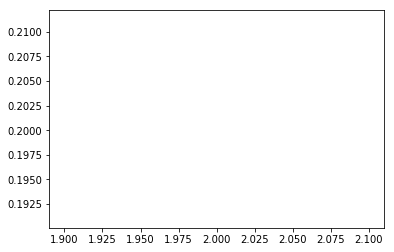

In [655]:
plt.plot(cluster_nums, silhouette_scores)
plt.show()

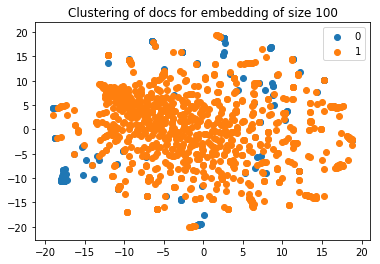

In [656]:
for i in range(cluster_num):
    points = X[clusters == i]
    plt.scatter(points[:,0], points[:,1], label=i)
plt.title("Clustering of docs for embedding of size 100")
plt.legend()
plt.show()

Не оч, попробуем иерархическую кластеризацию

## Hierarchical clustering

In [657]:
from scipy.cluster.hierarchy import *

In [658]:
Z = linkage(diffs, metric="cosine", method="average")

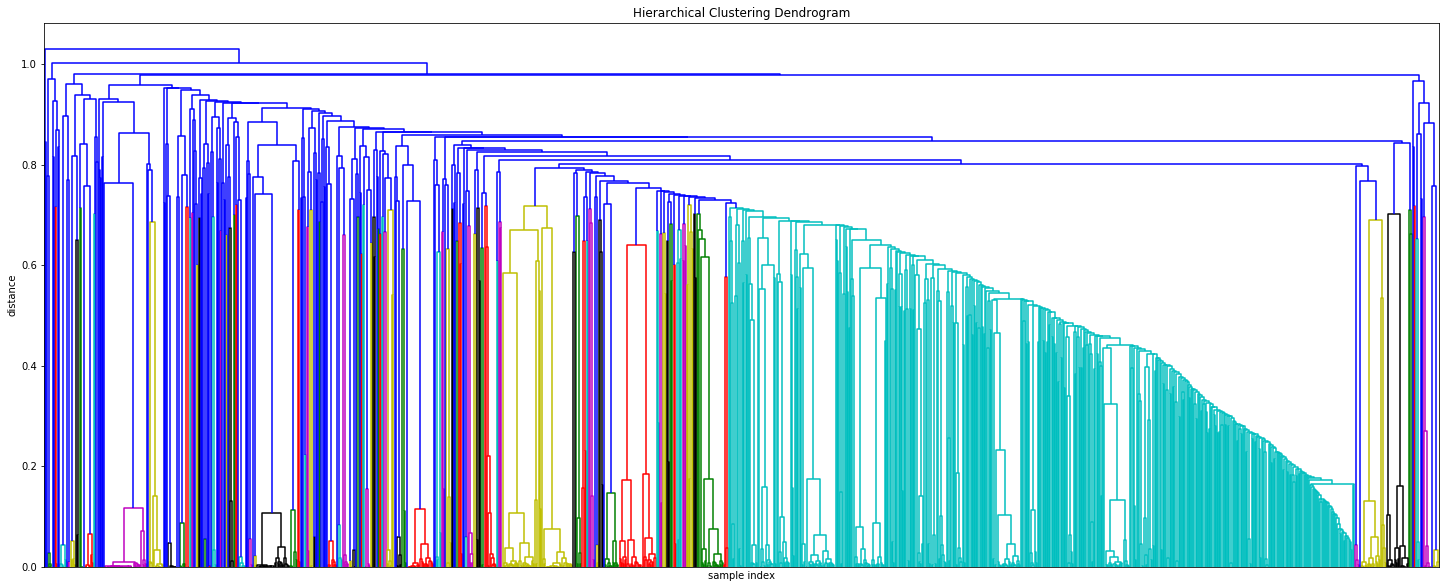

In [659]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.xticks([])
# cur_axes = plt.gca()
# cur_axes.axes.get_xaxis().set_ticks([])
plt.show()

In [660]:
from scipy.spatial.distance import pdist
cophenet(Z, pdist(diffs, metric="cosine"))

(0.7490016652740459,
 array([0.91274777, 0.78546381, 0.78546381, ..., 0.53345915, 0.10401087,
        0.53345915]))

In [661]:
silhouette_scores = []
for t in tqdm_notebook(np.arange(0.05, 1.05, 0.1)):
    Z = linkage(diffs, metric="cosine", method="average")
    clusters = fcluster(Z, criterion="distance", t=t)
#     print(np.unique(clusters))
    score = silhouette_score(diffs, clusters, metric='cosine')
    silhouette_scores.append(score)

KeyboardInterrupt: 

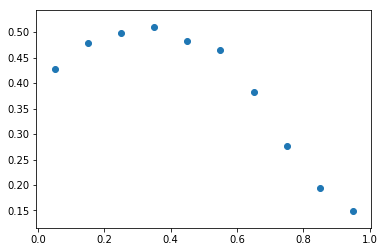

In [203]:
plt.scatter(np.arange(0.05, 1.05, 0.1), silhouette_scores)
plt.show()

In [662]:
clusters = fcluster(Z, criterion="distance", t=0.4)

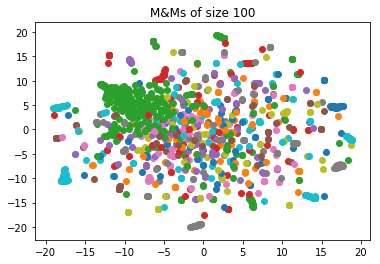

In [664]:
for i in np.unique(clusters):
    points = X[clusters == i]
    plt.scatter(points[:,0], points[:,1], label=i)
plt.title("M&Ms of size 100")
# plt.legend()
plt.show()

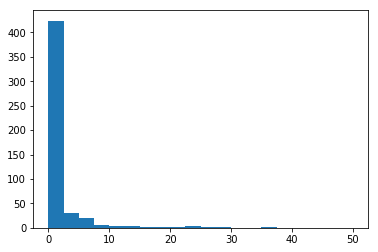

In [226]:
hist, _ = np.histogram(clusters, bins=500)
hist2 = plt.hist(hist, bins=20, range=(0, 50))
plt.show()

In [230]:
hist2[0].sum()

499.0

In [222]:
hist.sum() - hist[0]

1239

В общем тут я сдаюсь. Кажется, что для этого эмбеддинга ничего дельного не получится из-за того что он такой круглый

# Path Clustering. Event + attrs embedding

## Doc2Vec + Spherical KMeans

Получим эмбедденги для последовательностей атрибутов ивентов

In [233]:
data = pd.read_csv("data/train_test/train(in scope).csv")

In [237]:
data.head()

,Unnamed: 0,CASE,EVENT,SIMPLIFIED EVENT,EVENT TYPE,SYS DATE,CREATION DATE,POSTING DATE,DOCUMENT DATE,Company Code,Company Code Description,Document Type,Document Type Description,Document Category,Document Category Description,User ID,User Name,User Type,Vendor,Vendor Name,Material,Material Text,Material Description,Purchase Organisation,Purchase Organisation Description,Purchase Group,Quantity,Amount in Reporting Currency,Purchase Document,Purchase Document Line Item,Reference Document,Reference Document Line Item,Context,SELECT,START DATE,END DATE,CASE_EVENTATT,User Group,User Country,Vendor Industry,Company Code Country,EVENT AND USER,EVENT AND DOCTYPE,INVOICES_Q,INVOICES_A,GOODS RECIEVED_Q,GOODS RECIEVED_A,POS_Q,POS_A
0,0,2000475085-10,Purchase order,Purchase order,Purchasing document,2014-10-01 01:17:29,2014-10-01 00:00:00,NaN,NaN,3000.0,Unknown,ZNB,NaN,F,Purchase order,HIMPEHEN,NaN,NaN,33756,Unknown,100011201,Papier en karton,Papier en karton,3000,Unknown,WAI,-6280.0,-393.32,2000475085,10.0,2.000475e+09,10.0,Material type: Waste Materials; Material type:...,2 - Purchase Order; 2 - Purchase Order,2014/10/01 01:17:29,2014/10/01 01:17:29,2000475085-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3140,-196.66,-6280.0,-393.32
1,1,2000475085-10,Purchase order item updated,Purchase order item updated,Document management - PO,2014-10-10 03:02:09,NaN,NaN,NaN,3000.0,Unknown,ZNB,NaN,Not set,Purchase order,VLIEBEDI,NaN,NaN,33756,Unknown,100011201,Papier en karton,Papier en karton,3000,Unknown,WAI,NaN,NaN,2000475085,10.0,2.000475e+09,10.0,ME22N:EKPO - BPUMZ; 9380 -> 1; ME22N:EKPO - BR...,12 - PO changes; 12 - PO changes; 12 - PO chan...,2014/10/10 03:02:09,2014/10/10 03:02:09,2000475085-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2000475085-10,Purchase order item updated - amount,Purchase order item updated,Document management - PO,2014-10-10 03:02:09,NaN,NaN,NaN,3000.0,Unknown,ZNB,NaN,Not set,Purchase order,VLIEBEDI,NaN,NaN,33756,Unknown,100011201,Papier en karton,Papier en karton,3000,Unknown,WAI,NaN,NaN,2000475085,10.0,2.000475e+09,10.0,ME22N:EKPO - NETWR; 587.47 -> 196.66,12 - PO changes,2014/10/10 03:02:09,2014/10/10 03:02:09,2000475085-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2000475085-10,Purchase order item updated - quantity,Purchase order item updated,Document management - PO,2014-10-10 03:02:09,NaN,NaN,NaN,3000.0,Unknown,ZNB,NaN,Not set,Purchase order,VLIEBEDI,NaN,NaN,33756,Unknown,100011201,Papier en karton,Papier en karton,3000,Unknown,WAI,NaN,NaN,2000475085,10.0,2.000475e+09,10.0,ME22N:EKPO - MENGE; 1.000 -> 3140.000,12 - PO changes,2014/10/10 03:02:09,2014/10/10 03:02:09,2000475085-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2000475085-10,Goods Return (Goods Receipt for Purchase Order),Goods Return,Delivery (in scope),2014-10-10 03:15:16,2014-10-10 03:15:16,2014-10-10 00:00:00,NaN,3000.0,Unknown,WE,Goods receipt,WE,Goods Receipt for Purchase Order,VLIEBEDI,NaN,NaN,33756,Unknown,100011201,Papier en karton,Papier en karton,Purchase organisation from 3000,Purchase organisation from 3000,Purchase group from 3000,-3140.0,-196.66,2000475085,10.0,5.011839e+09,1.0,NaN,3a - Delivery (in scope),2014/10/10 03:15:16,2014/10/10 03:15:16,2000475085-10,NaN,NaN,NaN,NaN,NaN,Goods Return (Goods Receipt for Purchase Order...,NaN,NaN,NaN,NaN,NaN,NaN


In [263]:
feature = "Document Category Description"
np.unique(data[np.logical_not(data[feature].isnull())][feature])

array(['Account maintenance', 'Accounting document',
       'Consumption (Subcontracting)', 'Delivery (Stock Transfer)',
       'Goods Issue for Stock Transfer',
       'Goods Receipt for Purchase Order', 'Logistics invoice',
       'Purchase order', 'RS', 'Service Entry Sheet'], dtype=object)

In [249]:
np.logical_not(True)

False

In [309]:
features = ["CASE", "SIMPLIFIED EVENT","EVENT TYPE", "Document Type", "Document Category Description",
            "User ID", "Material", "Vendor", "Purchase Group"] 

In [310]:
for column in features:
    n = data[np.logical_not(data[column].isnull())].shape[0]
    m = data.shape[0]
    unique_values_num = np.unique(data[np.logical_not(data[column].isnull())][column]).size
    if n/m > 0.6:
        print(column, n/m, unique_values_num)

CASE 1.0 1240
SIMPLIFIED EVENT 1.0 27
EVENT TYPE 1.0 10
Document Type 1.0 13
Document Category Description 1.0 10
User ID 1.0 23
Material 1.0 215
Vendor 1.0 148
Purchase Group 1.0 14


In [311]:
cases = np.unique(data["CASE"])

In [312]:
data["Vendor"].fillna("Not set", inplace=True)

In [313]:
df = data[features]

In [315]:
df.head()

,CASE,SIMPLIFIED EVENT,EVENT TYPE,Document Type,Document Category Description,User ID,Material,Vendor,Purchase Group
0,2000475085-10,Purchase order,Purchasing document,ZNB,Purchase order,HIMPEHEN,100011201,33756,WAI
1,2000475085-10,Purchase order item updated,Document management - PO,ZNB,Purchase order,VLIEBEDI,100011201,33756,WAI
2,2000475085-10,Purchase order item updated,Document management - PO,ZNB,Purchase order,VLIEBEDI,100011201,33756,WAI
3,2000475085-10,Purchase order item updated,Document management - PO,ZNB,Purchase order,VLIEBEDI,100011201,33756,WAI
4,2000475085-10,Goods Return,Delivery (in scope),WE,Goods Receipt for Purchase Order,VLIEBEDI,100011201,33756,Purchase group from 3000


In [316]:
cases = np.unique(df["CASE"])

In [317]:
from collections import defaultdict

In [329]:
logs = defaultdict(list)

In [330]:
features = [
 'SIMPLIFIED EVENT',
 'EVENT TYPE',
 'Document Type',
 'Document Category Description',
 'User ID',
 'Material',
 'Vendor',
 'Purchase Group']

In [331]:
for case_id in tqdm_notebook(cases):
    case = df[df["CASE"] == case_id]
    d = defaultdict(list)
    for i in case.index:
        event = case.loc[i]
        for feature in features:
            d[feature].append(event[feature])
    for feature in features:
        logs[feature].append(d[feature])

In [341]:
dvs = dict()
for feature in tqdm_notebook(features):
    log = logs[feature]
    docs = []
    for i, case in enumerate(log):
        docs.append(TaggedDocument(case, [i]))
    if feature == "SIMPLIFIED EVENT":
        size = 100
    else:
        size = 50
    dv = Doc2Vec(docs, dm=0, size=size, window=3, min_count=0)
    dvs[feature] = dv

DEBUG:gensim.models.word2vec:Fast version of gensim.models.word2vec is being used
INFO:gensim.models.doc2vec:collecting all words and their counts
INFO:gensim.models.doc2vec:PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO:gensim.models.doc2vec:collected 27 word types and 1240 unique tags from a corpus of 1240 examples and 13506 words
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:min_count=0 retains 27 unique words (100% of original 27, drops 0)
INFO:gensim.models.word2vec:min_count=0 leaves 13506 word corpus (100% of original 13506, drops 0)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 27 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 18 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 1927 word corpus (14.3% of prior 13506)
INFO:gensim.models.word2vec:estimated required memory for 27 words and 100 dimensions: 531100 bytes
INFO:gensim.models.word2vec:resetting la

In [354]:
dv = dvs["SIMPLIFIED EVENT"]
docvecs = np.array([dv.docvecs[i] for i in range(len(logs["SIMPLIFIED EVENT"]))])
for feature in features[1:]:
    dv = dvs[feature]
    feature_docvecs = np.array([dv.docvecs[i] for i in range(len(logs[feature]))])
    docvecs = np.hstack((docvecs, feature_docvecs))

In [355]:
docvecs.shape

(1240, 450)

In [359]:
from sklearn.manifold import TSNE
X = TSNE(n_components=2, metric="cosine").fit_transform(docvecs)

In [362]:
X

array([[ -4.78550524,   8.38667338],
       [ -6.0525911 ,   9.63570292],
       [-14.66544581,   8.7099977 ],
       ...,
       [ -2.54920195,   6.75216566],
       [ -7.67605016,  10.52632807],
       [ -1.94347128,   7.39030985]])

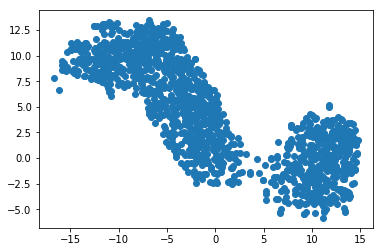

In [363]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [478]:
cluster_num = 2
skm = SphericalKMeans(n_clusters=cluster_num)
skm.fit(np.array(docvecs))
clusters = skm.predict(docvecs)
# score = silhouette_score(diffs, clusters, metric='cosine')
# silhouette_scores.append(score)

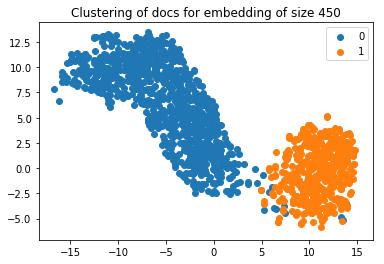

In [479]:
for i in np.unique(clusters):
    points = X[clusters == i]
    plt.scatter(points[:,0], points[:,1], label=i)
plt.title("Clustering of docs for embedding of size 450")
plt.legend()
plt.show()

In [496]:
log1 = pr.Log(list(np.array(logs["SIMPLIFIED EVENT"])[clusters == 1]))
log0 = pr.Log(list(np.array(logs["SIMPLIFIED EVENT"])[clusters == 0]))

In [497]:
len(log1)

401

In [498]:
len(log0)

839

In [499]:
log0.get_events()
plog0, paths, betas = prune(log0, coef=1)

INFO:root:Pruning...


In [500]:
plt.plot(betas)

In [501]:
log1.get_events()
plog1, paths, betas = prune(log1, coef=1)

INFO:root:Pruning...


In [502]:
plt.plot(betas)

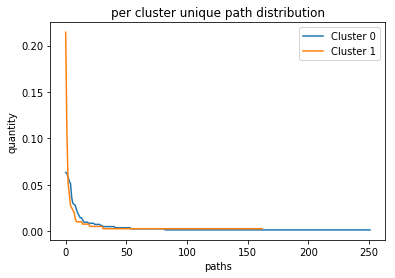

In [503]:
plt.title("per cluster unique path distribution")
plt.xlabel("paths")
plt.ylabel("quantity")
plt.legend(["Cluster 0", "Cluster 1"])
plt.show()

In [492]:
am = miners.AlphaMiner()

In [493]:
# log1.get_events()
plog1, paths, betas = prune(log1, coef=0.8)

INFO:root:Pruning...


In [494]:
am.apply(clean(plog1, inplace=True))

INFO:root:Cleaning...
DEBUG:root:Got task list
DEBUG:root:Got direct follows
DEBUG:root:Got causaieties
DEBUG:root:Got cycles
DEBUG:root:Got not causaieties
DEBUG:root:Got parallels
DEBUG:root:Got subsets
INFO:root:Processing 4094 subset of 12 events
DEBUG:root:Got Xl
DEBUG:root:Building Petri net


In [495]:
am.draw(output_file="pic/cluster1_doc2vec450_80%")

In [446]:
log0.get_events()
plog0, paths, betas = prune(log0, top=3)

INFO:root:Pruning...


In [447]:
betas

[0.0631704410011919, 0.06197854588796186, 0.058402860548271755]

In [437]:
am.apply(clean(plog0, inplace=True))

INFO:root:Cleaning...
DEBUG:root:Got task list
DEBUG:root:Got direct follows
DEBUG:root:Got causaieties
DEBUG:root:Got cycles
DEBUG:root:Got not causaieties
DEBUG:root:Got parallels
DEBUG:root:Got subsets
INFO:root:Processing 2046 subset of 11 events
DEBUG:root:Got Xl
DEBUG:root:Building Petri net


In [439]:
am.draw(output_file="pic/cluster0_doc2vec450")

In [476]:
cluster_nums = [i for i in range(2, 11)]
silhouette_scores = []
for cluster_num in tqdm_notebook(cluster_nums):
    skm = SphericalKMeans(n_clusters=cluster_num)
    skm.fit(docvecs)
    clusters = skm.predict(docvecs)
    score = silhouette_score(docvecs, clusters, metric='cosine')
    silhouette_scores.append(score)

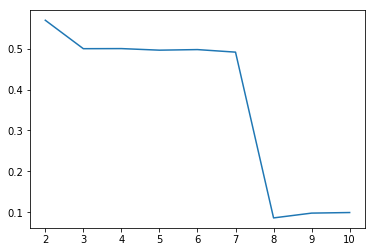

In [477]:
plt.plot(cluster_nums, silhouette_scores)
plt.show()

## Cluster analisys

### Event Description

In [506]:
cluster0_dict = {}
cluster1_dict = {}
for feature in features:
    log = np.array(logs[feature])
    cluster0_dict[feature] = log[clusters == 0]
    cluster1_dict[feature] = log[clusters == 1]

In [508]:
cluster1_dict

401

In [544]:
from collections import Counter
feature = "User ID"
items0 = [item for sublist in cluster0_dict[feature] for item in sublist]
counts0 = Counter(items0)
items1 = [item for sublist in cluster1_dict[feature] for item in sublist]
counts1 = Counter(items1)

In [546]:
user_counts0 = pd.DataFrame(list(counts0.items()), columns=["User ID", "count"])
user_counts1 = pd.DataFrame(list(counts1.items()), columns=["User ID", "count"])

In [555]:
keys = set(list(counts0.keys()) + list(counts1.keys()))
counts = {} 
for key in keys:
    counts[key] = [counts0.get(key, 0), counts1.get(key, 0)]

In [560]:
user_counts = pd.DataFrame(counts, index=["cluster0", "cluster1"])

In [570]:
user_counts.shape

(2, 23)

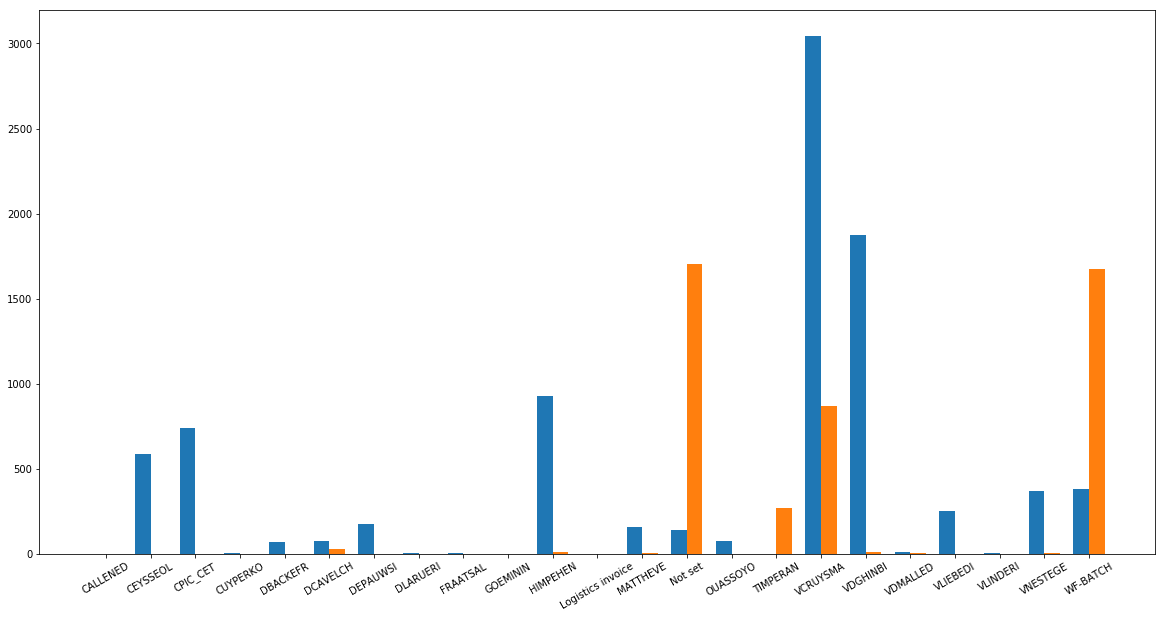

In [581]:
fig, ax = plt.subplots(figsize=(20, 10))
width = 0.35  # the width of the bars

ind = np.arange(1, user_counts.shape[1] + 1)
ax.bar(ind - width/2 , list(user_counts.loc["cluster0"]), width=width, label="Cluster 0")
ax.bar(ind + width/2, list(user_counts.loc["cluster1"]), width=width, label="Cluster 1")
ax.set_xticks(ind)
ax.set_xticklabels(labels=list(user_counts.columns), rotation=30)
plt.show()

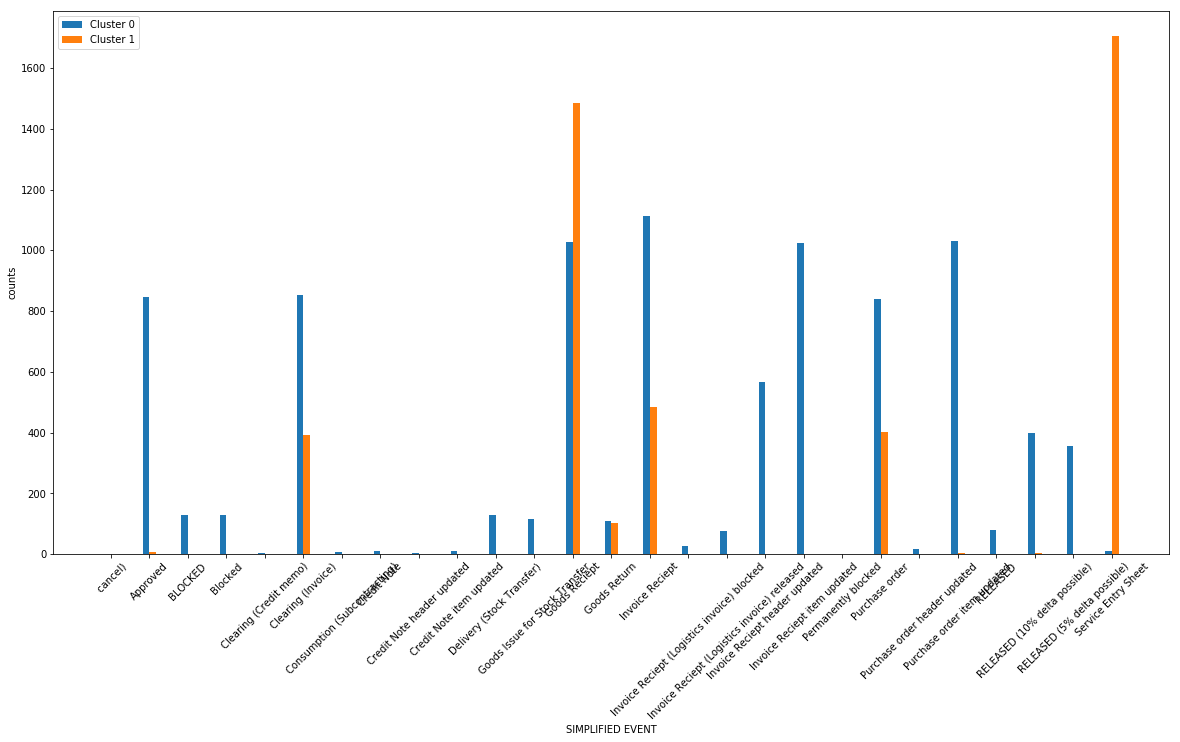

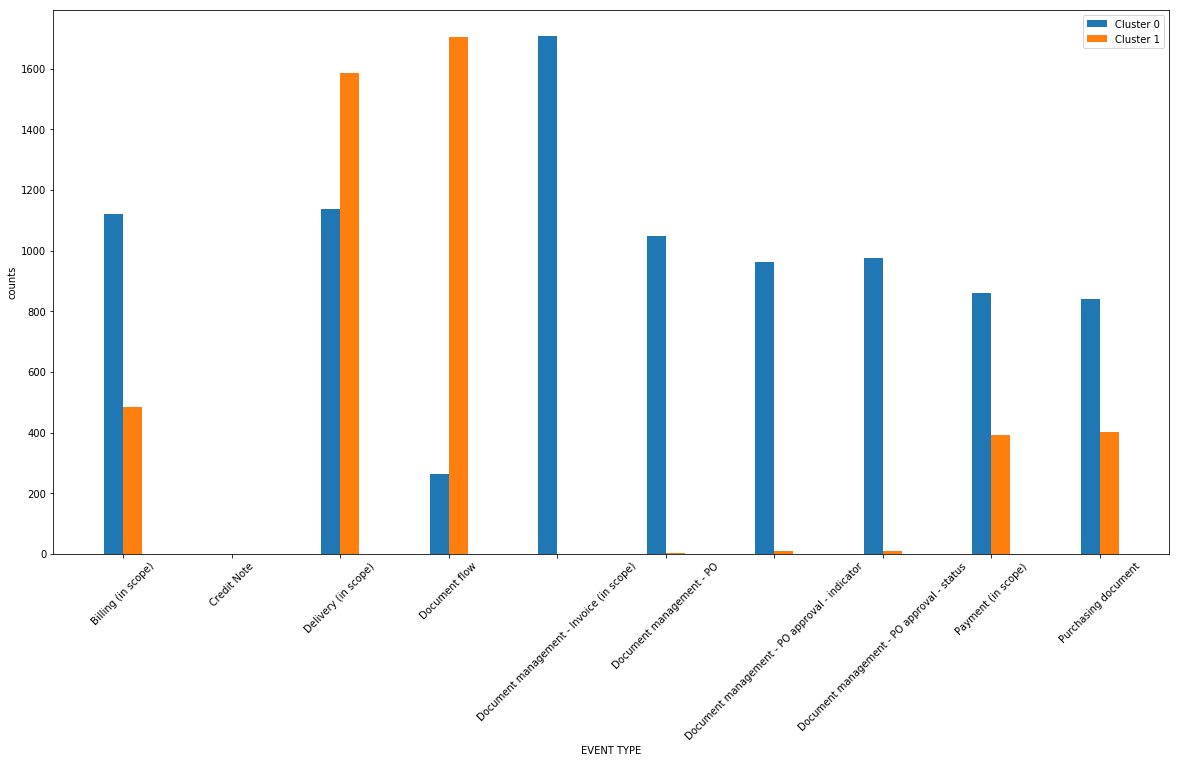

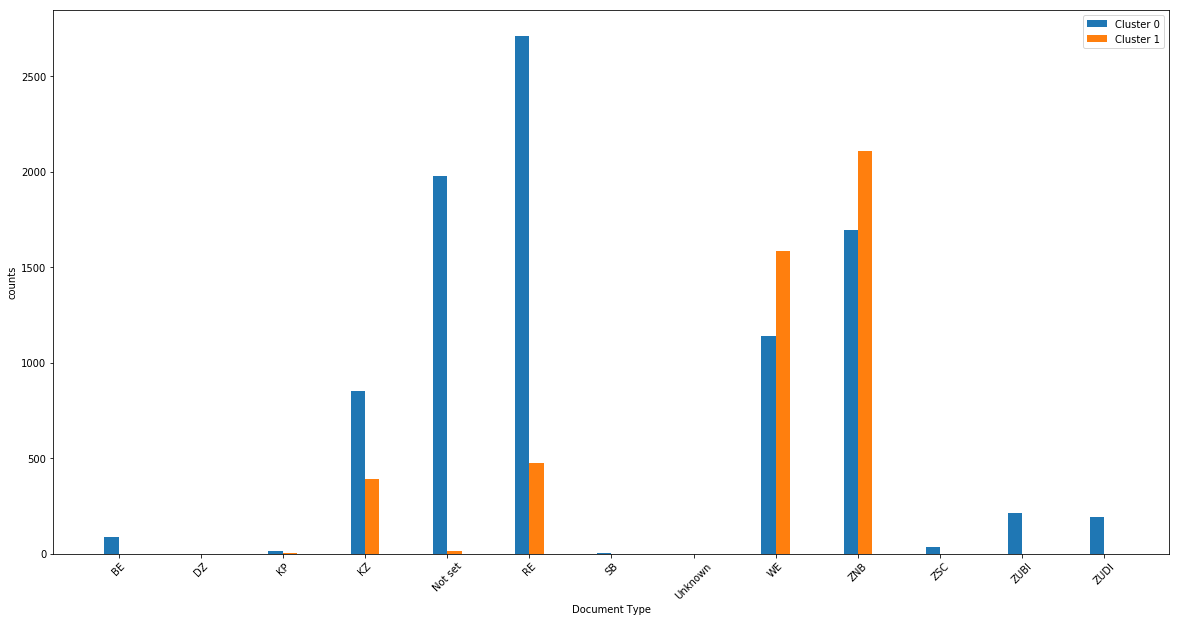

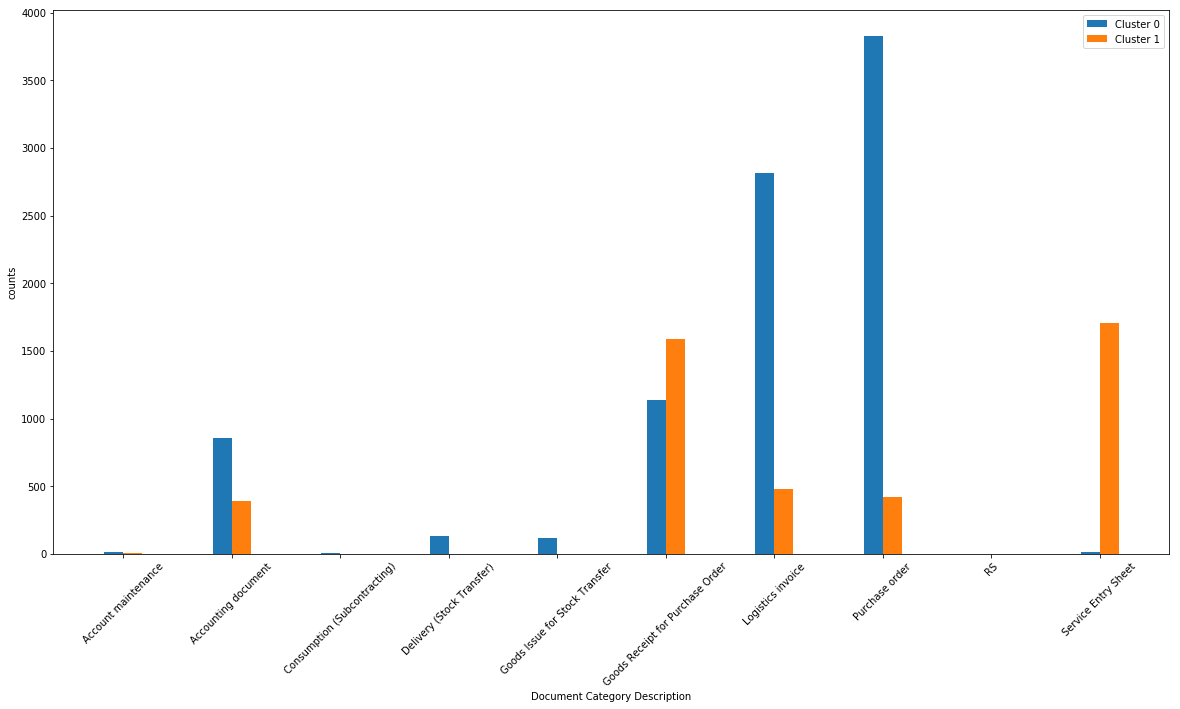

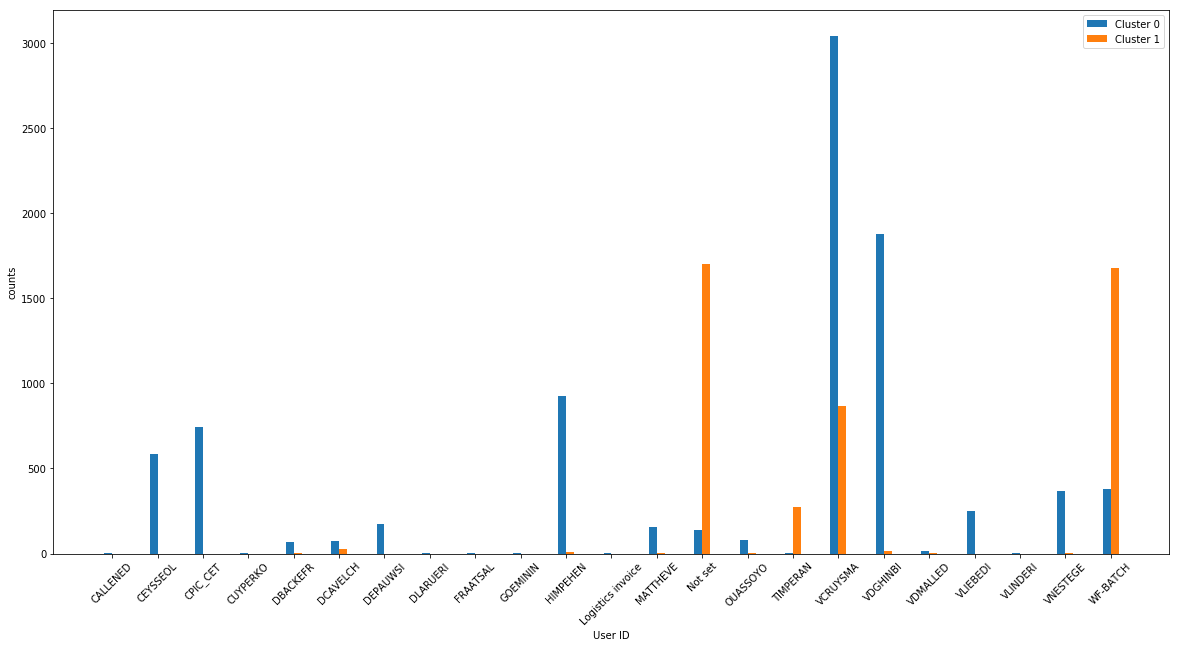

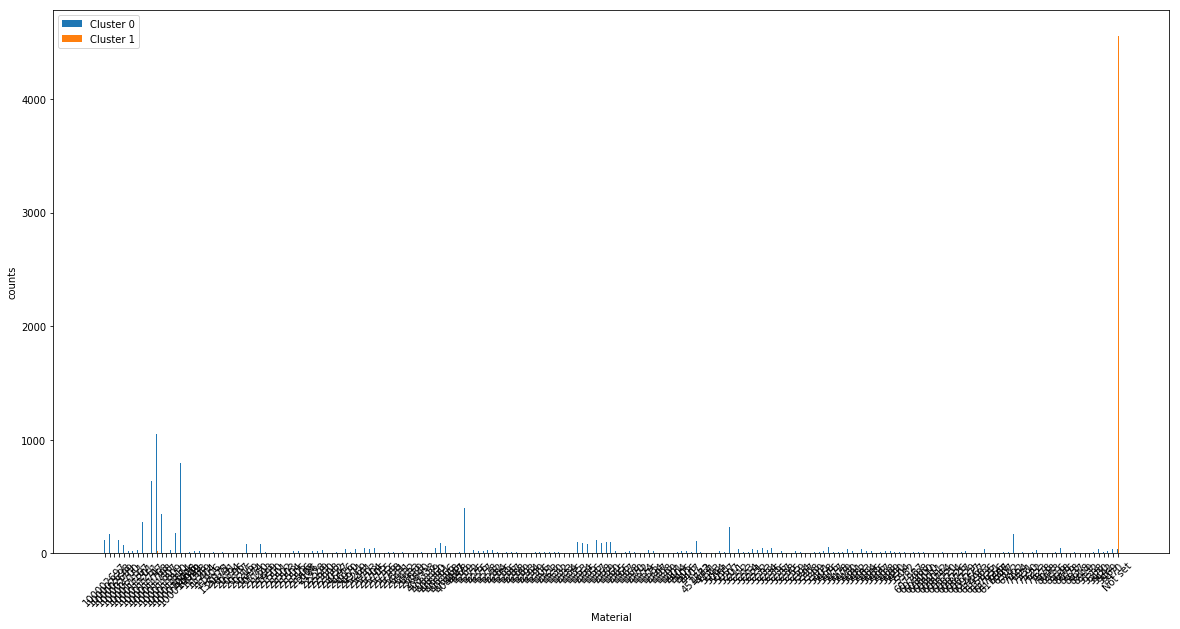

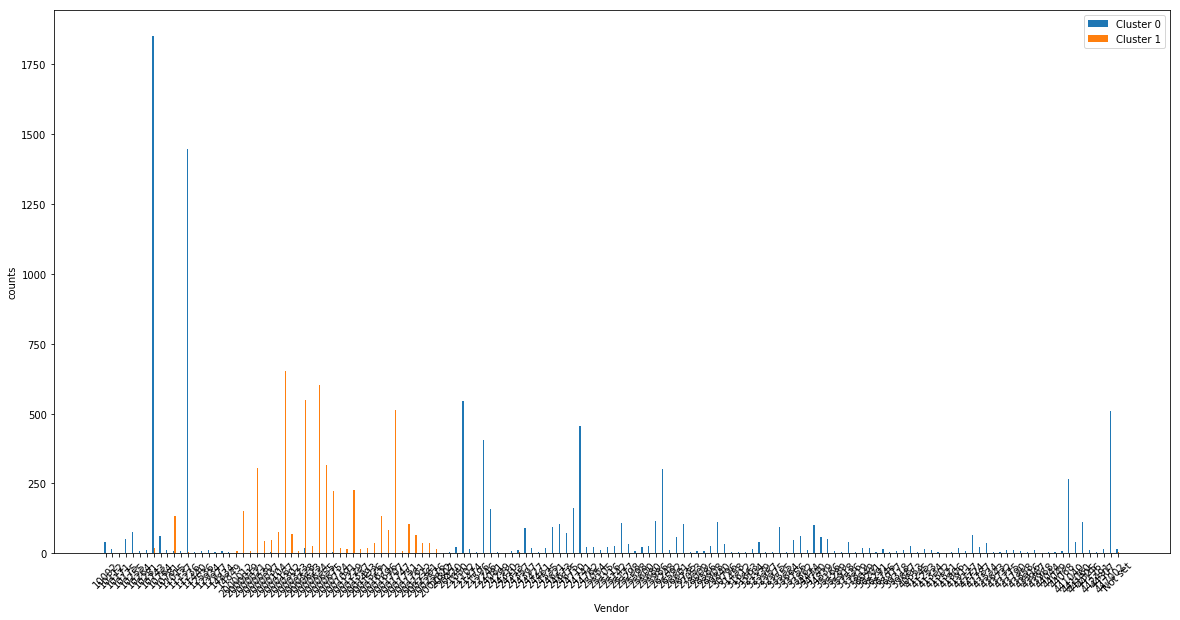

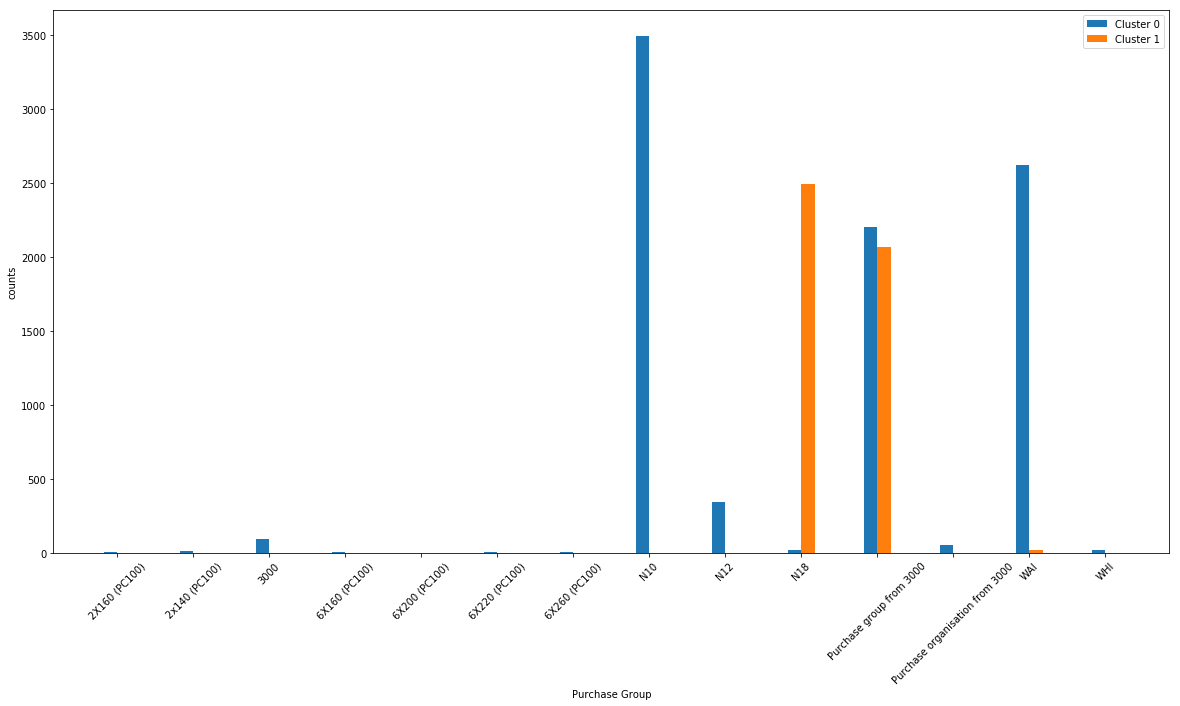

In [589]:
for feature in features:
    items0 = [item for sublist in cluster0_dict[feature] for item in sublist]
    counts0 = Counter(items0)
    items1 = [item for sublist in cluster1_dict[feature] for item in sublist]
    counts1 = Counter(items1)
    
    keys = set(list(counts0.keys()) + list(counts1.keys()))
    counts = {} 
    for key in keys:
        counts[key] = [counts0.get(key, 0), counts1.get(key, 0)]
    clusters_counts = pd.DataFrame(counts, index=["cluster0", "cluster1"])
    fig, ax = plt.subplots(figsize=(20, 10))
    width = 0.35  # the width of the bars

    ind = np.arange(1, 2*(clusters_counts.shape[1]), 2)
    ax.bar(ind - width/2 , list(clusters_counts.loc["cluster0"]), width=width, label="Cluster 0")
    ax.bar(ind + width/2, list(clusters_counts.loc["cluster1"]), width=width, label="Cluster 1")
    ax.set_xlabel(feature)
    ax.set_ylabel("counts")
    ax.set_xticks(ind)
    ax.legend()
    ax.set_xticklabels(labels=list(clusters_counts.columns), rotation=45)
    plt.show()

### Case Description

In [665]:
lens0 = [len(case) for case in cluster0]
lens1 = [len(case) for case in cluster1]

In [669]:
sns.distplot(lens0)
sns.distplot(lens1)
plt.xlabel("Path length")
plt.ylabel("Count")
plt.title("Path length distribution per cluster")
plt.legend(["Cluster 0", "Cluster 1"])
plt.show()

LinAlgError: singular matrix

In [607]:
max(pdist(docvecs, metric="cosine"))

1.7792370714341166

In [605]:
from scipy.spatial.distance import squareform
dist_mat = squareform(pdist(docvecs, metric="cosine"))

In [608]:
np.sort(dist_mat)

array([[0.        , 0.05584266, 0.05892218, ..., 1.64471105, 1.65853091,
        1.69683017],
       [0.        , 0.03487334, 0.0372101 , ..., 1.61354096, 1.62970005,
        1.74248308],
       [0.        , 0.01813862, 0.02081905, ..., 1.60064989, 1.61978662,
        1.73125705],
       ...,
       [0.        , 0.05949615, 0.0645836 , ..., 1.60828032, 1.62329591,
        1.66746729],
       [0.        , 0.03574155, 0.03610228, ..., 1.63616039, 1.6690467 ,
        1.75327966],
       [0.        , 0.0573461 , 0.06576817, ..., 1.64671978, 1.65462234,
        1.70843355]])

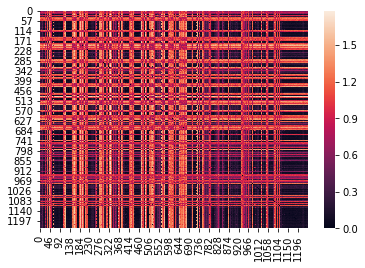

In [610]:
sns.heatmap(dist_mat)
plt.show()

In [618]:
cluster1 = docvecs[clusters == 1]
cluster0 = docvecs[clusters == 0]

In [635]:
means_diff = []
ids = []
for i in range(450):
    mean_diff = abs(np.mean(cluster0[:,i]) - np.mean(cluster1[:,i]))
    if mean_diff > 0.01:
        ids.append(i)
    means_diff.append(mean_diff)

In [636]:
len(ids)

40

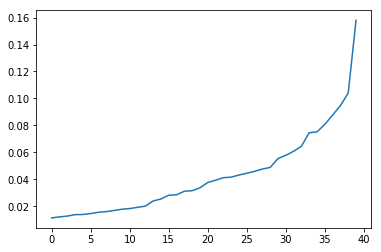

In [632]:
plt.plot(np.sort(np.array(means_diff)[ids]))
plt.show()

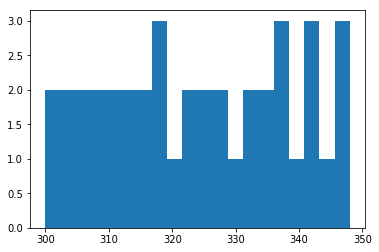

In [638]:
plt.hist(ids, bins=20)
plt.show()

Все признаки относятся к эмбеденгу материала

In [639]:
features

['SIMPLIFIED EVENT',
 'EVENT TYPE',
 'Document Type',
 'Document Category Description',
 'User ID',
 'Material',
 'Vendor',
 'Purchase Group']

Гипотезы по кластеру:
1. Туда попали мусорные или аномальные цепочки
2. Он структурно отличается от другого кластера
3. Нужны еще датесеты с разными параметрами

Что еще сделать:
1. Другие кластеризации
2. Как нибудь добавить вещественные признаки
3. Второй вариант эмбединга